In [1]:
#1. 1. Install PyPDF2 and py-readability-metric
!pip install nltk PyPDF2 py-readability-metrics wordcloud matplotlib

In [3]:
#2. In a new notebook, import nltk and run the following commands: 
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('vader_lexicon')
from nltk.corpus import stopwords
import nltk.data
from nltk.sentiment import SentimentIntensityAnalyzer
import PyPDF2
import re, string
import sys
!{sys.executable} -m pip install textstat
import textstat
from wordcloud import WordCloud


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Vanshika\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Vanshika\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vanshika\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Vanshika\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


###3. Read the two news stories found in this assignment on Canvas.  In a markdown cell in your notebook, briefly characterize the issue at hand and your impressions from a news reporting objectivity perspective. 


Both articles talk about the same thing i.e. plagiarism claims against the Harvard University’s president, Claudine Gay.

The Fox News article focuses on how big the issue is. It says there are over 40 new plagiarism complaints and talks about people criticizing Harvard for supporting her. The language feels more dramatic and emotional and uses words like “embattled” and “slapped with charges.” It sounds like the goal is to make the story feel urgent and controversial to the public.

The Reuters article, on the other hand feels calmer and more neutral. It mainly explains what Harvard and Claudine Gay are doing about the situation, that she will correct some citation mistakes in her dissertation and that a review found she didn’t commit serious misconduct. It gives dates, facts, and official statements instead of opinions.

In short, Fox News sounds more critical, while Reuters sounds more factual. Fox seems focused on the controversy; Reuters seems focused on reporting the facts.



In [5]:
#4. Use PyPDF2 to extract the text out of each document  
#a. Display the text  
#b. Briefly note any anomalies in your notebook 

import PyPDF2
FOX = "C:/Users/Vanshika/Desktop/Adv. prog. assignment/foxnews.pdf"
REUTERS = "C:/Users/Vanshika/Desktop/Adv. prog. assignment/reuters.pdf"

def read_pdf_text(pdf_path):
    """Extract text from a PDF using PyPDF2."""
    text = []
    with open(pdf_path, "rb") as f:
        reader = PyPDF2.PdfReader(f)
        for p in reader.pages:
            try:
                page_text = p.extract_text() or ""
            except Exception:
                page_text = ""
            text.append(page_text)
    return "\n".join(text)

def normalize_whitespace(s: str) -> str:
    """Fix hyphenated line breaks and normalize spaces/newlines."""
    s = re.sub(r"-\s*\n\s*", "", s)   # e.g., "attribu-\n tion" -> "attribution"
    s = re.sub(r"\r", "\n", s)
    s = re.sub(r"[ \t]+", " ", s)
    s = re.sub(r"\n{2,}", "\n\n", s)
    return s.strip()


text_fox_raw = read_pdf_text(FOX)
text_reuters_raw = read_pdf_text(REUTERS)


print("=== FOX (raw) preview ===\n", text_fox_raw[:800])
print("\n=== REUTERS (raw) preview ===\n", text_reuters_raw[:800])

text_fox = normalize_whitespace(text_fox_raw)
text_reuters = normalize_whitespace(text_reuters_raw)


=== FOX (raw) preview ===
 1 / 5Brian FloodEmbattled Harvard University President Claudine Gay hit
with more plagiarism charges
foxnews.com /media/embattled-harvard-university-president-claudine-gay-hit-more-plagiarism-charges
Media
Harvard ‘received a complaint outlining over 40 allegations of
plagiarism,’ according to the Free Beacon
 By Brian Flood  Fox News
Published December 20, 2023 12:59pm EST
Harvard president facing 40 new allegations of plagiarism
Fox News' Molly Line reports the latest on the allegations. 
Embattled Harvard University President Claudine Gay  has been slapped with additional
charges of plagiarism. 
The Washington Free Beacon  reported Harvard "received a complaint outlining over 40
allegations of plagiarism" against Gay on T uesday , noting a letter was sent to Harvard's
research integrity

=== REUTERS (raw) preview ===
 1 / 3Gabriella BorterHarvard president will submit dissertation edits after
plagiarism allegations
reuters.com /world/us/embattled-harvard-p

When I used PyPDF2 to pull out the text from both articles, most of the words came through clearly, but there were a few small issues like: 

-Some line breaks appeared in random spots, and a few words were split across lines.

-The headings, author names, and website links got mixed in with the main text.

-The Reuters file had extra phrases like “Acquire Licensing Rights” and “Advertisement” that aren’t part of the article itself.

-The Fox News file also included extra links and section titles (like “Media” or “Published December 20, 2023”) that broke the flow.

In [7]:
#5. Use NLTK to complete sentiment analysis for each of the articles 
#a. Compare the results from the two articles 
#b. Compare the results to your reading of the articles; do you agree with the outcome? 


sia = SentimentIntensityAnalyzer()

def split_sentences(text: str):
    """Try NLTK sentence tokenizer; fall back to regex if punkt_tab/punkt is missing."""
    try:
        from nltk.tokenize import sent_tokenize
        return [s for s in sent_tokenize(text) if s.strip()]
    except LookupError:
        return [s.strip() for s in re.split(r'(?<=[.!?])\s+', text) if s.strip()]

def sentiment_by_sentences(text: str):
    """Return mean (neg/neu/pos/compound) over sentences + the list of sentence scores."""
    sents = split_sentences(text or "")
    scores = [sia.polarity_scores(s) for s in sents]
    if not scores:
        return {"neg":0.0,"neu":1.0,"pos":0.0,"compound":0.0}, []
    avg = {
        "neg": sum(d["neg"] for d in scores)/len(scores),
        "neu": sum(d["neu"] for d in scores)/len(scores),
        "pos": sum(d["pos"] for d in scores)/len(scores),
        "compound": sum(d["compound"] for d in scores)/len(scores),
    }
    return avg, scores


fox_sent_doc, fox_sent_sents = sentiment_by_sentences(text_fox)
reuters_sent_doc, reuters_sent_sents = sentiment_by_sentences(text_reuters)

print("=== Article-level sentiment (mean over sentences) ===")
print(f"{'Metric':>10s} | {'FOX':>8s} | {'REUTERS':>8s}")
print("-"*34)
for k in ["neg","neu","pos","compound"]:
    print(f"{k:>10s} | {fox_sent_doc[k]:8.3f} | {reuters_sent_doc[k]:8.3f}")



=== Article-level sentiment (mean over sentences) ===
    Metric |      FOX |  REUTERS
----------------------------------
       neg |    0.059 |    0.047
       neu |    0.879 |    0.932
       pos |    0.061 |    0.021
  compound |    0.042 |   -0.143


Results:

FOX: neg 0.059, neu 0.879, pos 0.061, compound +0.042
REUTERS: neg 0.047, neu 0.932, pos 0.021, compound −0.143

#(a) Compare the results from the two articles 
Neutrality: Reuters is more neutral overall (neu 0.932 vs 0.879).
Overall tone (compound): Reuters is more negative (−0.143) and Fox as slightly positive (+0.042).
Positivity: Fox has more positive words (pos 0.061 vs 0.021).
Negativity: Both are low on negativity; Fox is a bit higher on neg, but the compound pulls Reuters down because it has very little positive language mixed in. (more neutral)

#(b). Compare the results to your reading of the articles; do you agree with the outcome?
My read: Fox feels more dramatic, while Reuters feels more factual.
Reuters is overall more negative (compound −0.143) and Fox slightly positive (+0.042).

Why the mismatch?
Reuters uses many words as negative (e.g., allegations, errors, misconduct, resign), and fewer positive terms so the compound skews negative.
Fox includes lots of meta text (links, headings) and some positive/neutral verbs that bring down the negativity, which pushes  its compound slightly positive.
The scores can differ from human judgment about which piece reads more sensational.
By the numbers, Reuters is coded as more negative overall, even though Fox reads more sensational to me. I partially disagree with the model and explain the gap by the specific word choices each outlet uses.

In [9]:
#6. Run sentiment analysis on the article headlines  
HEADLINE_FOX = "Embattled Harvard University President Claudine Gay hit with more plagiarism charges"
HEADLINE_REUTERS = "Harvard president will submit dissertation edits after plagiarism allegations"

fox_headline_score = sia.polarity_scores(HEADLINE_FOX)
reuters_headline_score = sia.polarity_scores(HEADLINE_REUTERS)

print("=== Headline Sentiment ===")
print(f"{'Metric':>10s} | {'FOX':>8s} | {'REUTERS':>8s}")
print("-"*34)
for k in ["neg","neu","pos","compound"]:
    print(f"{k:>10s} | {fox_headline_score[k]:8.3f} | {reuters_headline_score[k]:8.3f}")


=== Headline Sentiment ===
    Metric |      FOX |  REUTERS
----------------------------------
       neg |    0.192 |    0.000
       neu |    0.808 |    1.000
       pos |    0.000 |    0.000
  compound |   -0.335 |    0.000


Results:

FOX headline: neg = 0.192, neu = 0.808, pos = 0.000, compound = −0.335

REUTERS headline: neg = 0.000, neu = 1.000, pos = 0.000, compound = 0.000

Interpretation:
The Fox News headline (“Embattled Harvard University President Claudine Gay hit with more plagiarism charges”) is clearly negative, the word embattled and the phrase hit with charges carry a harsh, critical tone.
The Reuters headline (“Harvard president will submit dissertation edits after plagiarism allegations”) reads as completely neutral, it just states a factual update without emotional words.

Do the headline scores agree with the overall article sentiment?
Yes, mostly. The Fox headline’s negative compound (−0.335) fits with its more dramatic style and focus on controversy. The Reuters headline’s perfectly neutral score (0.000) matches its factual and balanced writing tone.


In [11]:
#7. Using py-readability-metrics complete 2-3 different readability scores 
#a. Discuss what the chosen metric is measuring 
#b. Compare the scores from both articles 

print("\nFOX — Readability")
fox_fre  = textstat.flesch_reading_ease(text_fox)
fox_fog  = textstat.gunning_fog(text_fox)
fox_smog = textstat.smog_index(text_fox)
print("  Flesch Reading Ease:", round(fox_fre, 2))
print("  Gunning Fog Index:", round(fox_fog, 2))
print("  SMOG Index:", round(fox_smog, 2))

print("\nREUTERS — Readability")
reu_fre  = textstat.flesch_reading_ease(text_reuters)
reu_fog  = textstat.gunning_fog(text_reuters)
reu_smog = textstat.smog_index(text_reuters)
print("  Flesch Reading Ease:", round(reu_fre, 2))
print("  Gunning Fog Index:", round(reu_fog, 2))
print("  SMOG Index:", round(reu_smog, 2))

print("\n=== Side-by-side Comparison ===")
print(f"{'Metric':>18s} | {'FOX':>8s} | {'REUTERS':>8s}")
print("-"*40)
print(f"{'FleschReadingEase':>18s} | {fox_fre:8.2f} | {reu_fre:8.2f}")
print(f"{'GunningFogIndex':>18s} | {fox_fog:8.2f} | {reu_fog:8.2f}")
print(f"{'SMOGIndex':>18s}        | {fox_smog:8.2f} | {reu_smog:8.2f}")



FOX — Readability
  Flesch Reading Ease: 21.7
  Gunning Fog Index: 21.08
  SMOG Index: 18.33

REUTERS — Readability
  Flesch Reading Ease: 24.64
  Gunning Fog Index: 18.72
  SMOG Index: 16.83

=== Side-by-side Comparison ===
            Metric |      FOX |  REUTERS
----------------------------------------
 FleschReadingEase |    21.70 |    24.64
   GunningFogIndex |    21.08 |    18.72
         SMOGIndex        |    18.33 |    16.83


a. What these metrics measure:

Flesch Reading Ease: tells how easy or hard a text is to read. Higher = simpler language and shorter sentences. Lower = more complex or academic writing.
Gunning Fog Index: estimates how many years of education someone needs to understand the text. Higher = harder to read.
SMOG Index: also measures years of education required, focusing on complex words. Higher = harder to read.

b. Comparison of results:
Metric	FOX	REUTERS
Flesch Reading Ease	21.7	24.6
Gunning Fog Index	21.1	18.7
SMOG Index	18.3	16.8

Interpretation:
Both articles are difficult to read (scores in the 20s ≈ academic or professional level).
The Reuters article has a slightly higher Flesch Reading Ease and lower Fog and SMOG values, meaning it’s a bit easier to follow than the Fox piece.
The Fox article high Fog and SMOG scores show that it uses slightly denser or more complicated sentence structures, which might come from more dramatic phrasing or repeated quotes.
Reuters leans a little clearer and straightforward, while Fox’s language feels more intense.

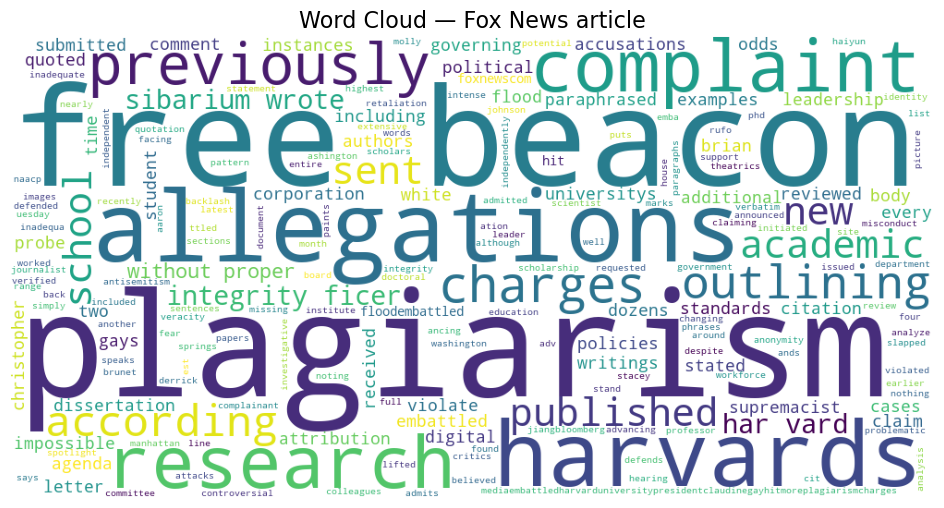

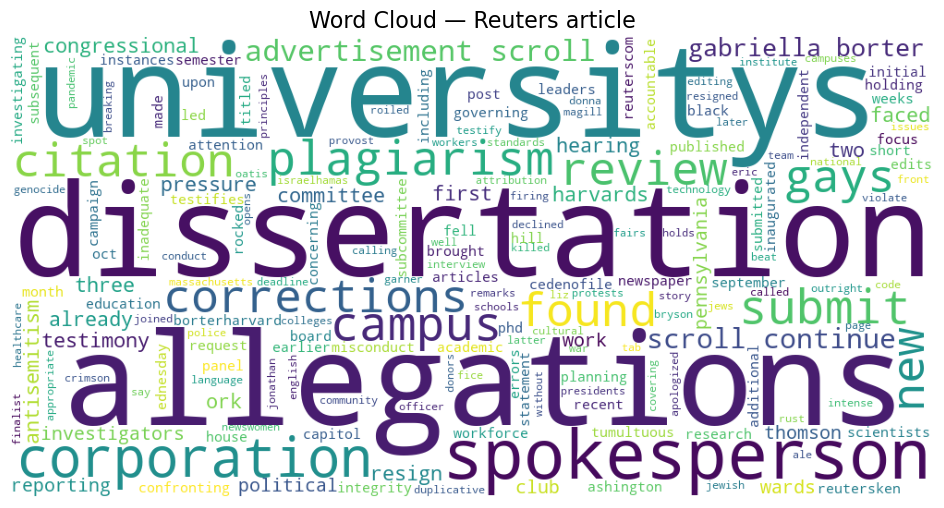

In [13]:
#8. Using wordcloud, create word clouds for both articles 


nltk.download('stopwords', quiet=True)

def clean_for_wordcloud(text, extra_stop=None):
    text = text.lower()
    text = text.translate(str.maketrans("", "", string.punctuation))
    tokens = nltk.word_tokenize(text)
    sw = set(stopwords.words("english"))
    if extra_stop:
        sw |= set(extra_stop)
    tokens = [t for t in tokens if t.isalpha() and t not in sw and len(t) > 2]
    return " ".join(tokens)


extra_sw = {
    "harvard","university","president","claudine","gay",
    "reuters","fox","news","said","also","will",
    "dec","december","u","us","photo","acquire","licensing","rights",
    "file","via","getty","reporter","reports","reported","media","category","video","link"
}

fox_wc_text = clean_for_wordcloud(text_fox, extra_stop=extra_sw)
reuters_wc_text = clean_for_wordcloud(text_reuters, extra_stop=extra_sw)

def show_cloud(text, title):
    wc = WordCloud(width=1000, height=500, background_color="white").generate(text)
    plt.figure(figsize=(12,6))
    plt.imshow(wc)
    plt.title(title, fontsize=16)
    plt.axis("off")
    plt.show()

show_cloud(fox_wc_text, "Word Cloud — Fox News article")
show_cloud(reuters_wc_text, "Word Cloud — Reuters article")


Cooments on word cloud:

Fox News word cloud: The biggest words focus on the allegations, e.g., terms like plagiarism, allegations, complaint, charges. This matches the article’s emphasis on the scale of accusations and criticism.

Reuters word cloud: Dominant words center on process and actions, e.g., dissertation, corrections, corporation, campus, universties, review. This reflects a more procedural framing of what happened and what the university is doing next.

Contrast: Fox’s cloud highlights accusation language, while Reuters highlights procedure language, consistent with the tone differences seen in the sentiment and readability sections.